In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from scipy.optimize import fsolve
from IPython.display import HTML
from tqdm import tqdm
import pickle
from scipy.fft import fft
import matplotlib.cm as cm

import visualisation as vis
from delta_hes_model import *
from analysis import *

plt.rcParams['text.usetex'] = True
hescolor1 = '#fdc776'  # light
hescolor2 = '#fc4e2a'  # dark
hescolor3 = '#8b1a0e'  # dark red with a warm tone

# Single internal oscillator with an external Delta source

This Jupyter Notebook runs simulations for an internal oscillator with an external Delta source. This Delta source can be fixed or oscillating. The code runs simulations for various values of Delta external and then analyses these systems. 

In [2]:
#set the lattice of the cells 
P = 3
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0 
w_h = 1
w_coupling = 1
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)


num_tsteps = 40000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20., 20.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=1, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


# Run simulations

In [ ]:
# running data for fixed delta varying between 0 and 0.1
delta_fixed = np.linspace(0, 0.1, 26)
results_fixed = np.zeros((len(delta_fixed), num_tsteps, 3))

for i, delta in enumerate(delta_fixed):
    h, m_h, d, m_d = simulate_fixed_delta(num_tsteps, dt, delta, lattice, params)
    
    results_fixed[i,:,0] = h[:,1].flatten()
    results_fixed[i,:,1] = m_h[:,1].flatten()
    results_fixed[i,:,2] = d[:,1].flatten()

# calculate the period of the uncoupled oscillator for later simulations
period_uncoupled = estimate_period_from_peaks(results_fixed[0,:,0].flatten(), time=np.arange(num_tsteps)*dt)[0]

100%|██████████| 39999/39999 [00:03<00:00, 10730.75it/s]


In [ ]:
delta_amplitude_weak = 0.01
delta_amplitude_strong = 0.05
delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]

results_oscillating_weak = np.zeros((len(delta_periods), len(delays), num_tsteps, 2))
results_oscillating_strong = np.zeros((len(delta_periods), len(delays), num_tsteps, 2))

for i, delta_period in enumerate(delta_periods):
    for j, delay in enumerate(delays):
        delta_oscillator_weak = (np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_period) + 1) * delta_amplitude_weak
        delta_oscillator_strong = (np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_period) + 1) * delta_amplitude_strong

        h, m_h, d, m_d = simulate_oscillating_delta(num_tsteps, dt, delta_oscillator_weak, delay, lattice, params)

        results_oscillating_weak[i,j,:,0] = h[:,1].flatten()
        results_oscillating_weak[i,j,:,1] = d[:,1].flatten()

        h, m_h, d, m_d = simulate_oscillating_delta(num_tsteps, dt, delta_oscillator_strong, delay, lattice, params)

        results_oscillating_strong[i,j,:,0] = h[:,1].flatten()
        results_oscillating_strong[i,j,:,1] = d[:,1].flatten()

 82%|████████▏ | 32601/39999 [00:04<00:00, 7479.64it/s]

In [ ]:
periods = np.array([-50, -10, 10, 50]) + np.round(period_uncoupled)
external_strength = np.linspace(0, 0.05, 41)

results_osc_strength = np.zeros((len(periods), len(external_strength), num_tsteps, 3))

for i in range(len(periods)):
    for j in range(len(external_strength)):
        print(f"Evaluating period {periods[i]} with external strength {external_strength[j]}")
        delta_oscillator = external_delta_oscillator(num_tsteps, dt, periods[i], external_strength[j])
        h, m_h, d, m_d = simulate_oscillating_delta(num_tsteps, dt, delta_oscillator, 0, lattice, params)

        results_osc_strength[i,j,:,0] = h[:,1].flatten()
        results_osc_strength[i,j,:,1] = m_h[:,1].flatten()
        results_osc_strength[i,j,:,2] = d[:,1].flatten()

with open('results_osc_strength.pickle', 'wb') as f:
    pickle.dump(results_osc_strength, f)

# Load data 

In [3]:
delta_fixed = np.linspace(0, 0.1, 26)
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_fixed_delta.pickle', 'rb') as f:
    results_fixed = pickle.load(f)

# calculate the period of the uncoupled oscillator for later simulations
period_uncoupled = estimate_period_from_peaks(results_fixed[0,:,0].flatten(), time=np.arange(num_tsteps)*dt)[0]

delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]

with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_oscillating_0.05.pickle', 'rb') as f:
    results_oscillating_strong = pickle.load(f)

with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_oscillating_0.01.pickle', 'rb') as f:
    results_oscillating_weak = pickle.load(f)

periods = np.array([-50, -10, 10, 50]) + np.round(period_uncoupled)
external_strength = np.linspace(0, 0.05, 41)

with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_osc_strength.pickle', 'rb') as f:
    results_osc_strength = pickle.load(f)



# Fixed Delta

Calculating period, mean value and amplitude

In [4]:
start_time = 2000

h_mean = np.mean(results_fixed[:,start_time:,0], axis=1)
d_mean = np.mean(results_fixed[:,start_time:,2], axis=1)

amplitude_h = np.zeros(len(delta_fixed))
amplitude_d = np.zeros(len(delta_fixed))
period_h = np.zeros(len(delta_fixed))
period_d = np.zeros(len(delta_fixed))

for i in range(len(delta_fixed)):
    amplitude_h[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,0])[0]
    amplitude_d[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,2])[0]

    amplitude_d = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
    amplitude_h = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

    if amplitude_h[i] > 0.5:
        period_h[i] = estimate_period_from_peaks(results_fixed[i,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_h[i] = None

    if amplitude_d[i] > 0.5:
        period_d[i] = estimate_period_from_peaks(results_fixed[i,start_time:,2], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_d[i] = None


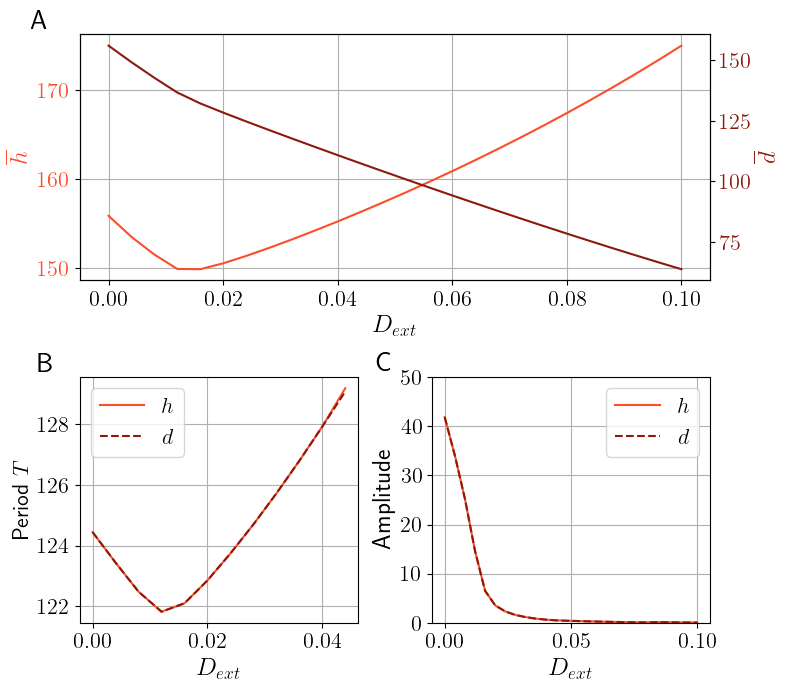

In [ ]:
# --------------------------------------
# Create the figure and GridSpec layout
# --------------------------------------
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# ------------------------------------------------------------
# ----------------- Panel A: Top Full Width -----------------
# ------------------------------------------------------------
axA_left = fig.add_subplot(gs[0, :])    # Span both columns

# Plot h_mean on left y-axis
line_h_mean, = axA_left.plot(
    delta_fixed, h_mean, 
    label='h mean',
    color=hescolor2
)

axA_left.set_xlabel(r'$D_{ext}$', fontsize=18)
axA_left.set_ylabel(r'$\overline{h}$', fontsize=18, color=hescolor2)
axA_left.tick_params(axis='y', labelcolor=hescolor2)
axA_left.tick_params(axis='x', labelsize=16)
axA_left.tick_params(axis='y', labelsize=16)
axA_left.grid()
# Right y-axis for d_mean
axA_right = axA_left.twinx()

line_d_mean, = axA_right.plot(
    delta_fixed, d_mean,
    label='d mean',
    color=hescolor3
)

axA_right.set_ylabel(r'$\overline{d}$', fontsize=18, color=hescolor3)
axA_right.tick_params(axis='y', labelcolor=hescolor3)
axA_right.tick_params(axis='y', labelsize=16)

# Combine legends
lines = [line_h_mean, line_d_mean]
labels = [l.get_label() for l in lines]
# axA_left.legend(lines, labels, loc='upper right', fontsize=12)

# Add letter A
axA_left.text(-0.08, 1.1, 'A', transform=axA_left.transAxes,
              fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# ---------------- Panel B: Bottom Left ---------------------
# ------------------------------------------------------------
axB = fig.add_subplot(gs[1, 0])

axB.plot(delta_fixed, period_h, label=r'$h$', color=hescolor2)
axB.plot(delta_fixed, period_d, label=r'$d$', color=hescolor3, linestyle='--')

axB.set_xlabel(r'$D_{ext}$', fontsize=18)
axB.set_ylabel(r'Period $T$', fontsize=16)
axB.legend(fontsize=16)
axB.grid()
# axB.set_xlim(0, max(delta_fixed))
# axB.set_ylim(110, 130)
axB.tick_params(axis='x', labelsize=16)
axB.tick_params(axis='y', labelsize=16)

# Add letter B
axB.text(-0.15, 1.1, 'B', transform=axB.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# ---------------- Panel C: Bottom Right --------------------
# ------------------------------------------------------------
axC = fig.add_subplot(gs[1, 1])

axC.plot(delta_fixed, amplitude_h, label=r'$h$', color=hescolor2)
axC.plot(delta_fixed, amplitude_d, label=r'$d$', color=hescolor3, linestyle='--')

axC.set_xlabel(r'$D_{ext}$', fontsize=18)
axC.set_ylabel('Amplitude', fontsize=18)
axC.legend(fontsize=16)
axC.grid()
# axC.set_xlim(0, max(delta_fixed))
axC.tick_params(axis='x', labelsize=16)
axC.tick_params(axis='y', labelsize=16)
axC.set_ylim(0, 50)
# Add letter C
axC.text(-0.2, 1.1, 'C', transform=axC.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ------------------------------------------------------------
# Layout adjustments
# ------------------------------------------------------------
plt.tight_layout()
# plt.savefig('delta-bath-fixed.png', dpi=600, bbox_inches='tight')
plt.show()


In [4]:
D_ext_0 = 0.008
D_ext_1 = 0.02 # external delta concentration
D_ext_2 = 0.1


m_h_plot = np.linspace(0, 50, 100)*1
h_plot = np.linspace(0, 300, 100)*1


# Calculate nullclines
h_null_plot, m_h_null_plot = nullclines_Hes(m_h_plot, h_plot, p_h, l, gamma_h, gamma_m)
h_null_ext_0, m_h_null_ext_0 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_0, p_h, l, gamma_h, gamma_m)
h_null_ext_1, m_h_null_ext_1 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_1, p_h, l, gamma_h, gamma_m)
h_null_ext_2, m_h_null_ext_2 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_2, p_h, l, gamma_h, gamma_m)
# m_h_null_ext_2, h_null_ext_2 = nullclines_Hes_deltabath(m_h_plot, h_plot, D_ext_2, p_h, l, gamma_h, gamma_m)



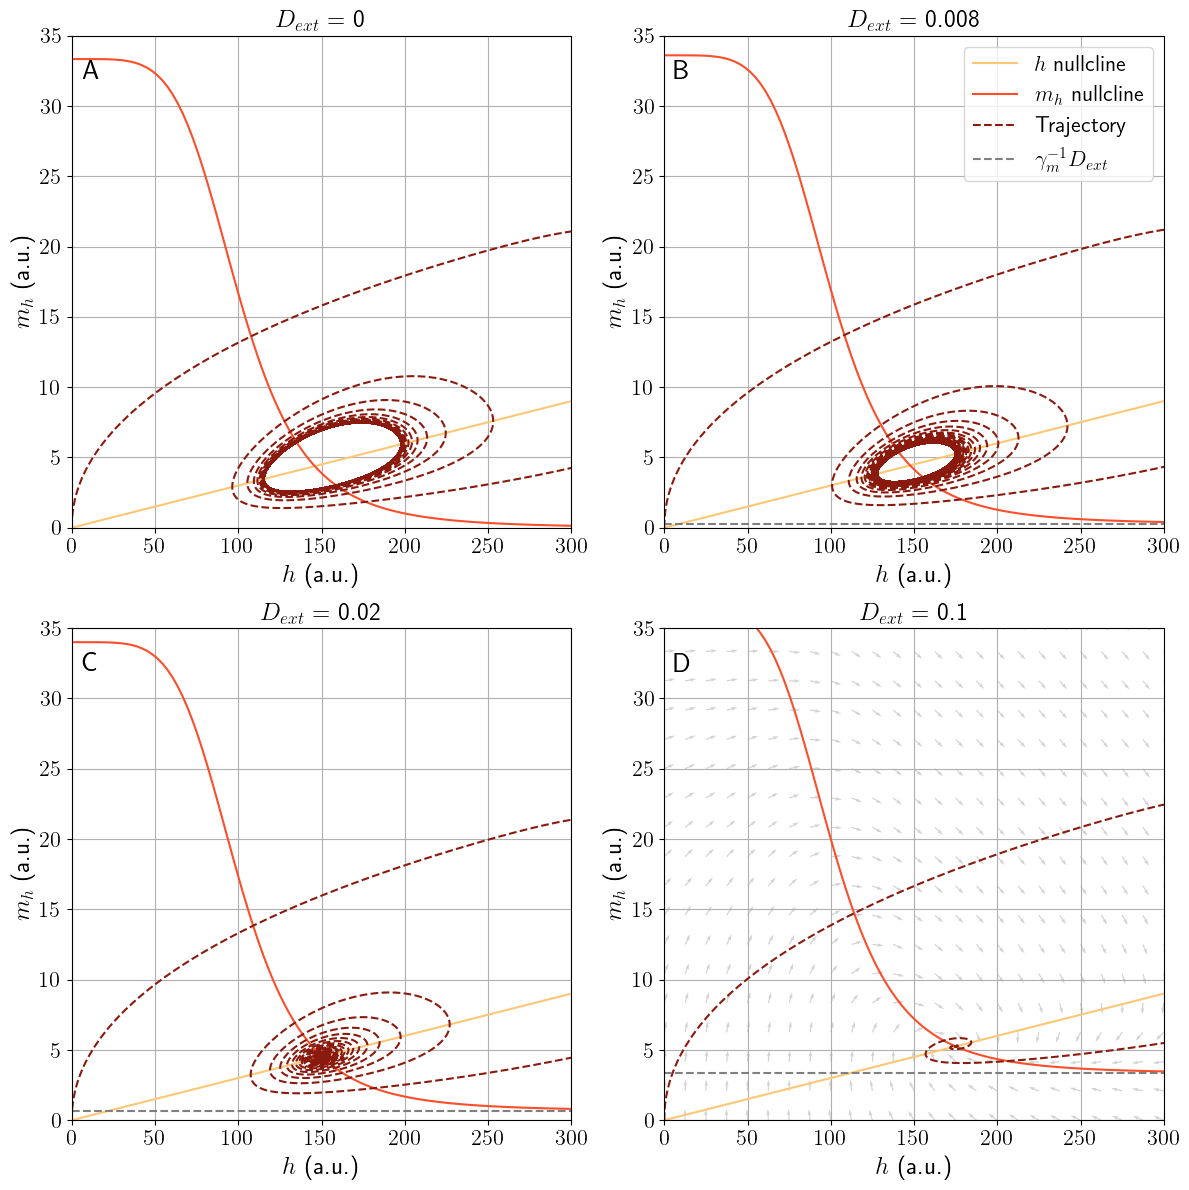

In [7]:
h = np.linspace(0, 300, 25)
m = np.linspace(0, 50, 25)

H, M = np.meshgrid(h, m)

# Define vector field components (U, V)
U = dh_dt(H, M, params) # x-component of vectors
V = dmh_dt(M, H, D_ext_2/w_coupling, params, lattice) /gamma_m # y-component of vectors


# Normalize the vectors to unit magnitude
magnitude = np.sqrt(U**2 + V**2)
# Avoid division by zero
magnitude[magnitude == 0] = 1  
U_normalized = U / magnitude
V_normalized = V / magnitude

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Letters to annotate subplots
letters = ['A', 'B', 'C', 'D']

# --------- First subplot ---------
ax = axs[0, 0]
ax.plot(h_null_plot, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_plot,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[0, :, 0], results_fixed[0, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
# ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ = 0', fontsize=18)
ax.text(0.02, 0.95, letters[0], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Second subplot ---------
ax = axs[0, 1]
ax.plot(h_null_ext_0, m_h_plot,  label=r'$h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_0,  label=r'$m_h$ nullcline', color = hescolor2)
ax.plot(results_fixed[2, :, 0], results_fixed[2, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_0/gamma_m, ls='--', color='gray', label=r'$\gamma_m^{-1}D_{ext}$')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ = ' + str(delta_fixed[2]), fontsize=18)
ax.text(0.02, 0.95, letters[1], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Third subplot ---------
ax = axs[1, 0]
ax.plot(h_null_ext_1, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_1,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[5, :, 0], results_fixed[5, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_1/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m$')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
# ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ = ' + str(delta_fixed[5]), fontsize=18)
ax.text(0.02, 0.95, letters[2], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

# --------- Fourth subplot ---------
ax = axs[1, 1]
ax.plot(h_null_ext_2, m_h_plot,  label=r'$m_h$ nullcline', color = hescolor1)
ax.plot(h_plot, m_h_null_ext_2,  label=r'$h$ nullcline', color = hescolor2)
ax.plot(results_fixed[-1, :, 0], results_fixed[-1, :, 1], 
        ls = '--', label = 'Trajectory', color = hescolor3)
ax.axhline(D_ext_2/gamma_m, ls='--', color='gray', label=r'$D_{ext}\gamma_m^{-1}$')
ax.quiver(H, M, U_normalized, V_normalized, color='lightgray', label='')
ax.set_xlabel(r'$h$ (a.u.)', fontsize=18)
ax.set_ylabel(r'$m_h$ (a.u.)', fontsize=18)
ax.set_xlim(0, 300)
ax.set_ylim(0, 35)
ax.grid()
ax.tick_params(labelsize=16)
# ax.legend(fontsize=16)
ax.set_title(r'$D_{ext}$ = ' + str(delta_fixed[-1]), fontsize=18)
ax.text(0.02, 0.95, letters[3], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()

# Optional save
# plt.savefig('delta-bath-fixed-limit-cycles.png', dpi=600)

plt.show()


# Oscillating Delta bath

calculation of periods, amplitudes and shifts

In [5]:
delta_periods = [60, 70, 80, 90, 100, 120, 125, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 155, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
delays = [0, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 50]

start_time = 2000
amplitude_limit = 0.01

amplitude_h_osc_weak = np.zeros((len(delta_periods), len(delays)))
amplitude_d_osc_weak = np.zeros((len(delta_periods), len(delays)))
period_h_osc_weak = np.zeros((len(delta_periods), len(delays)))
period_d_osc_weak = np.zeros((len(delta_periods), len(delays)))

amplitude_h_osc_strong = np.zeros((len(delta_periods), len(delays)))
amplitude_d_osc_strong = np.zeros((len(delta_periods), len(delays)))
period_h_osc_strong = np.zeros((len(delta_periods), len(delays)))
period_d_osc_strong = np.zeros((len(delta_periods), len(delays)))

results_oscillating = results_oscillating_weak
for i in range(len(delta_periods)):
    for j in range(len(delays)):
        amplitude_h_osc_weak[i,j] = estimate_amplitude_from_peaks(results_oscillating_weak[i,j,start_time:,0])[0]
        amplitude_d_osc_weak[i,j] = estimate_amplitude_from_peaks(results_oscillating_weak[i,j,start_time:,1])[0]
        amplitude_h_osc_strong[i,j] = estimate_amplitude_from_peaks(results_oscillating_strong[i,j,start_time:,0])[0]
        amplitude_d_osc_strong[i,j] = estimate_amplitude_from_peaks(results_oscillating_strong[i,j,start_time:,1])[0]

        # amplitude_d_osc = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
        # amplitude_h_osc = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

        if amplitude_h_osc_weak[i,j] > amplitude_limit:
            period_h_osc_weak[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_h_osc_weak[i,j] = None

        if amplitude_d_osc_weak[i,j] > amplitude_limit:
            period_d_osc_weak[i,j] = estimate_period_from_peaks(results_oscillating[i,j,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_d_osc_weak[i,j] = None  
        
        if amplitude_h_osc_strong[i,j] > amplitude_limit:
            period_h_osc_strong[i,j] = estimate_period_from_peaks(results_oscillating_strong[i,j,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_h_osc_strong[i,j] = None

        if amplitude_d_osc_strong[i,j] > amplitude_limit:
            period_d_osc_strong[i,j] = estimate_period_from_peaks(results_oscillating_strong[i,j,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
        else:
            period_d_osc_strong[i,j] = None

colours = vis.get_distinguishable_ylgn_colors(len(delays), min_val=0.3, max_val=0.8)

periods_osc_strength = np.zeros((len(periods), len(external_strength)))
amplitude_osc_strength = np.zeros((len(periods), len(external_strength)))

for i in range(len(periods)):
    for j in range(len(external_strength)):
        periods_osc_strength[i,j] = estimate_period_from_peaks(results_osc_strength[i,j,:,0], time=np.arange(num_tsteps)*dt)[0]
        amplitude_osc_strength[i,j] = estimate_amplitude_from_peaks(results_osc_strength[i,j,:,0])[0]



In [7]:
# find the shift between the external delta peaks and the internal delta peaks
shift = np.zeros((len(delta_periods), len(delays)))
start_time = 2000

for i in range(len(delta_periods)):
    external_signal = np.sin(np.arange(num_tsteps) * dt * 2 * np.pi / delta_periods[i]) * 0.05 + 0.05
    for j in range(len(delays)):
        period, peaks_external = estimate_period_from_peaks(external_signal[start_time:], time=np.arange(num_tsteps-start_time)*dt)
        period, peaks_internal = estimate_period_from_peaks(results_oscillating_strong[i,j,start_time:,1], time=np.arange(num_tsteps-start_time)*dt)
        shift[i,j] = find_shift(peaks_external/dt, peaks_internal/dt)

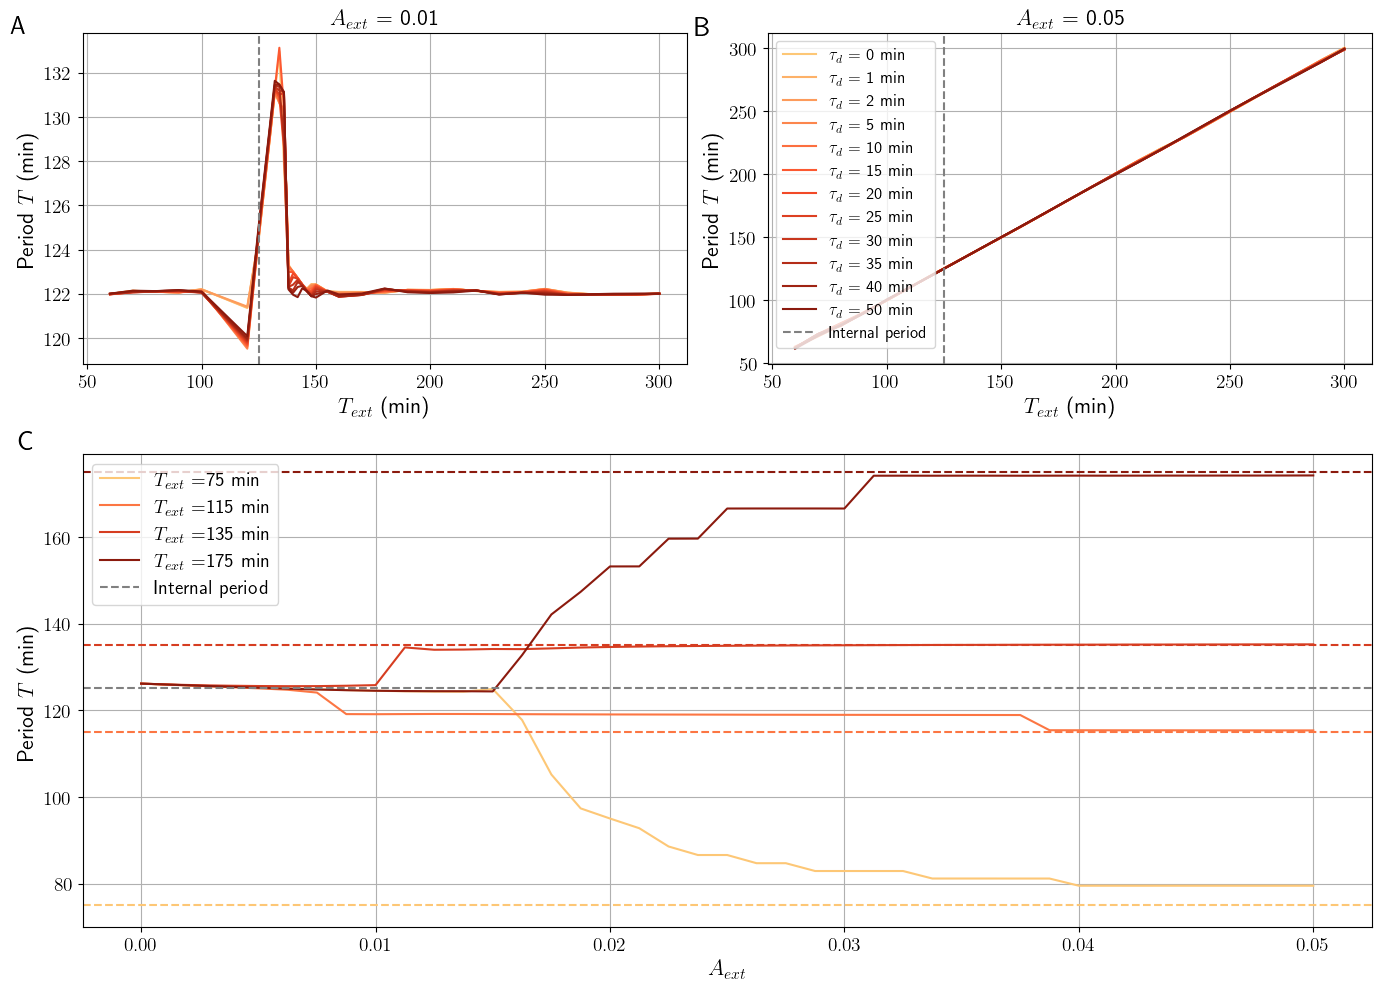

In [15]:

# Define figure + GridSpec
# ----------------------------------------------------------
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[0.7, 1])

# ----------------------------------------------------------
# ---- Panel A: Weak coupling (top left) -------------------
# ----------------------------------------------------------
axA = fig.add_subplot(gs[0,0])

# Assume results_oscillating = results_oscillating_weak
# Plot the period curves for weak coupling
colours_delays = vis.get_hes_colors(len(delays))

for j in range(len(delays)):
    axA.plot(delta_periods, period_d_osc_weak[:,j],
             label=fr'$\tau_d$ = {delays[j]}',
             color=colours_delays[j])

axA.axvline(period_uncoupled, ls='--', color='gray', label='Internal period')

axA.set_xlabel(r'$T_{ext}$ (min)', fontsize=16)
axA.set_ylabel(r'Period $T$ (min)', fontsize=16)
axA.set_title(r'$A_{ext}$ = 0.01', fontsize=16)
# axA.legend(fontsize=12)
axA.grid()
axA.tick_params(axis='x', labelsize=14)
axA.tick_params(axis='y', labelsize=14)

# Add letter A
axA.text(-0.12, 1.05, 'A', transform=axA.transAxes,
         fontsize=18, fontweight='bold', va='top')

# ----------------------------------------------------------
# ---- Panel B: Strong coupling (top right) ----------------
# ----------------------------------------------------------
axB = fig.add_subplot(gs[0,1])

for j in range(len(delays)):
    axB.plot(delta_periods, period_d_osc_strong[:,j],
             label=fr'$\tau_d$ = {delays[j]} min',
             color=colours_delays[j])

axB.axvline(period_uncoupled, ls='--', color='gray', label='Internal period')

axB.set_xlabel(r'$T_{ext}$ (min)', fontsize=16)
axB.set_ylabel(r'Period $T$ (min)', fontsize=16)
axB.set_title(r'$A_{ext}$ = 0.05', fontsize=16)
axB.legend(fontsize=12)
axB.grid()
axB.tick_params(axis='x', labelsize=14)
axB.tick_params(axis='y', labelsize=14)

# Add letter B
axB.text(-0.12, 1.05, 'B', transform=axB.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ----------------------------------------------------------
# ---- Panel C: Period vs A_D plot (bottom spanning both) --
# ----------------------------------------------------------
axC = fig.add_subplot(gs[1, :])
colours_periods = vis.get_hes_colors(len(periods))
for i in range(len(periods)):
    axC.plot(
        external_strength,
        periods_osc_strength[i,:],
        color=colours_periods[i],
        label=r'$T_{ext}$ =' + str(round(periods[i])) + ' min'
    )
    axC.axhline(periods[i], ls='--', color=colours_periods[i])
axC.axhline(period_uncoupled, ls='--', color='gray', label='Internal period')

axC.set_xlabel(r'$A_{ext}$', fontsize=16)
axC.set_ylabel(r'Period $T$ (min)', fontsize=16)
axC.legend(fontsize=14)
axC.grid()
axC.tick_params(axis='x', labelsize=14)
axC.tick_params(axis='y', labelsize=14)

# Add letter C
axC.text(-0.05, 1.05, 'C', transform=axC.transAxes,
         fontsize=20, fontweight='bold', va='top')

# ----------------------------------------------------------
# Layout and save
# ----------------------------------------------------------
plt.tight_layout()
# plt.savefig('delta-bath-oscillating.png', dpi=600, bbox_inches='tight')
plt.show()


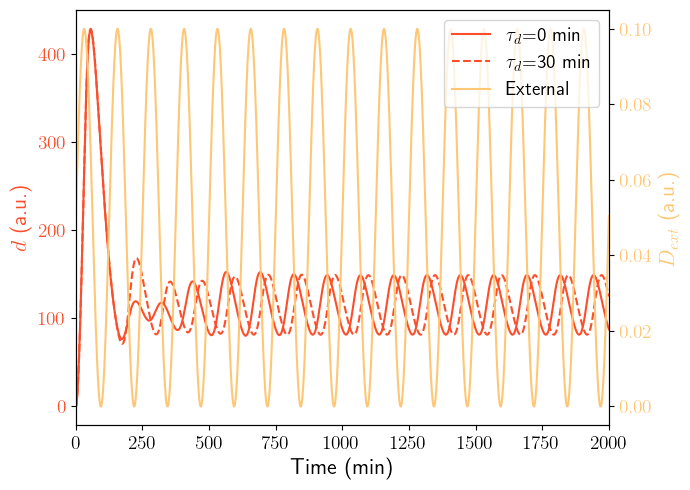

In [18]:
# Time axis
time_minutes = np.arange(num_tsteps) * dt
time_minutes_half = np.arange(num_tsteps//2) * dt

# Data
i = 6
j0 = 0
j8 = 8

d_j0 = results_oscillating_strong[i, j0, :, 1]
d_j8 = results_oscillating_strong[i, j8, :, 1]
external_signal = external_delta_oscillator(num_tsteps, dt, delta_periods[i], 0.05)


# Create figure and axes
fig, ax1 = plt.subplots(figsize=(7,5))

# Plot d for j=0
ax1.plot(
    time_minutes_half, 
    d_j0, 
    label=fr'$\tau_d$={delays[j0]} min', 
    color=hescolor2
)

# Plot d for j=8
ax1.plot(
    time_minutes_half, 
    d_j8, 
    label=fr'$\tau_d$={delays[j8]} min', 
    color=hescolor2, 
    linestyle='--'
)

# Secondary axis for external signal
ax2 = ax1.twinx()
ax2.plot(
    time_minutes, 
    external_signal, 
    label='External', 
    color=hescolor1, 
    linestyle='-'
)

# Axis styling
ax1.set_xlabel('Time (min)', fontsize=16)
ax1.set_ylabel(r'$d$ (a.u.)', fontsize=16, color=hescolor2)
ax1.tick_params(axis='y', labelcolor=hescolor2, labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2.set_ylabel(r'$D_{ext}$ (a.u.)', fontsize=16, color=hescolor1)
ax2.tick_params(axis='y', labelcolor=hescolor1, labelsize=14)

ax1.set_xlim(0, 2000)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2, 
    fontsize=14, 
    loc='upper right'
)

# Add subplot letter


plt.tight_layout()
# plt.savefig('delta-bath-delay-shift-combined.png', dpi=600, bbox_inches='tight')
plt.show()


[ 0  8 16 24 32 40]


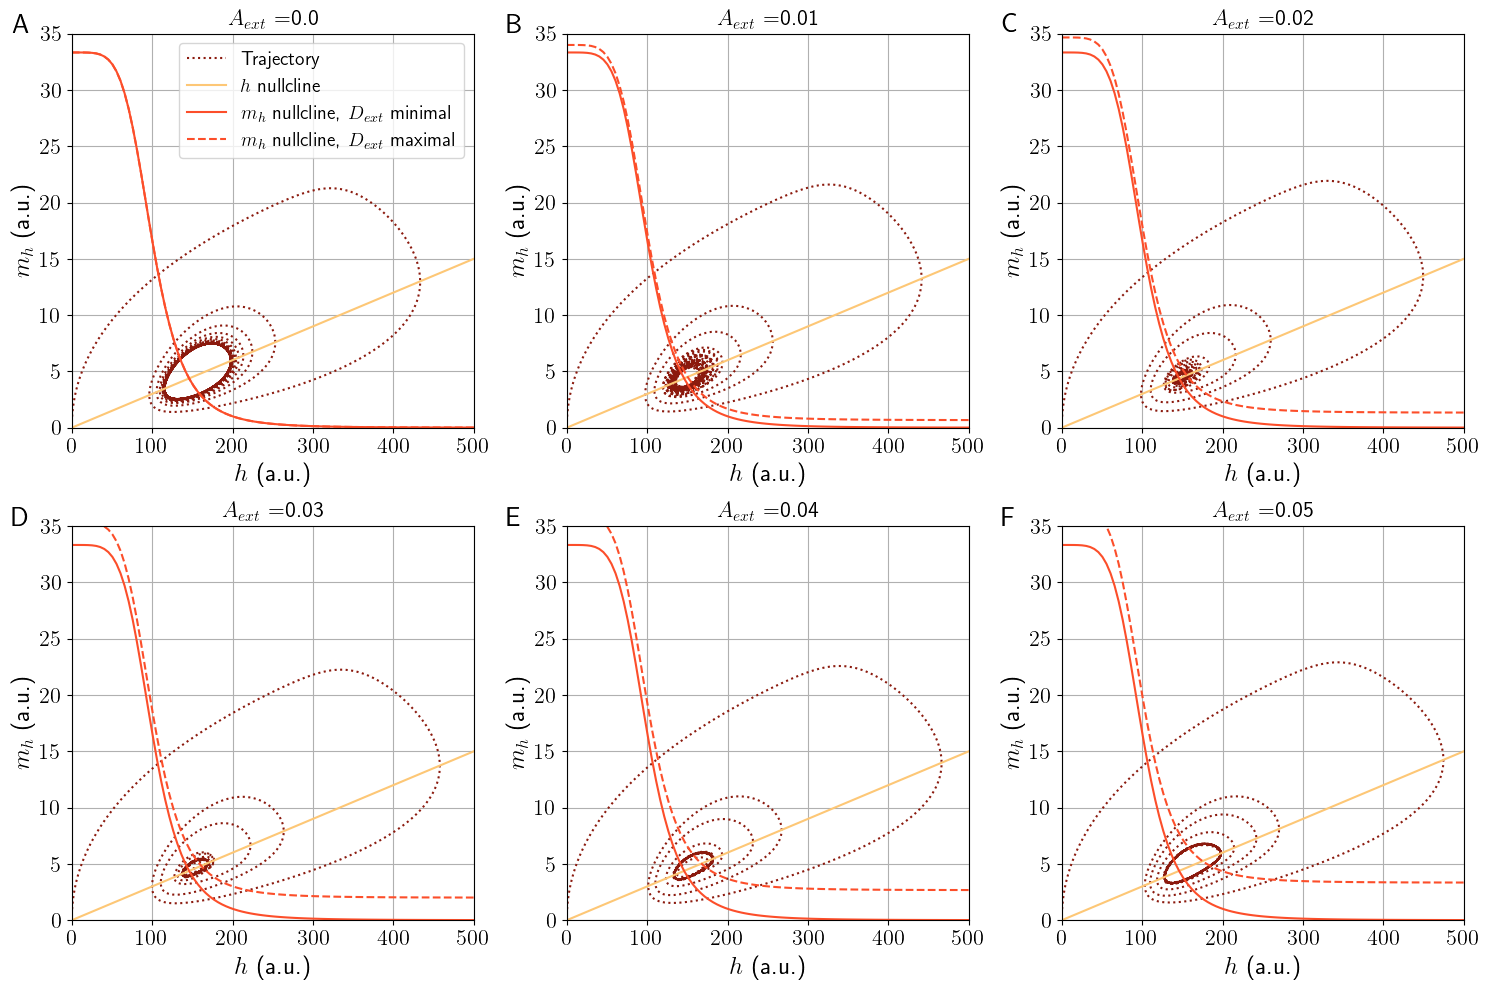

In [ ]:

i_period = 3
i_ext_strength = -1
timepoint = 10000

m_h_plot = np.linspace(0, 50, 100)*1
h_plot = np.linspace(0, 500, 100)*1

strength_range = np.linspace(0, 5, 6, dtype=int)*8
print(strength_range)

# Letters to label subplots
letters = ['A', 'B', 'C', 'D', 'E', 'F']

plt.figure(figsize=(15, 10))

for idx, i_ext_strength in enumerate(strength_range):
    limit_cycle_case = results_osc_strength[i_period, i_ext_strength]

    limit_cycle_external = external_delta_oscillator(
        num_tsteps, dt,
        periods[i_period],
        external_strength[i_ext_strength]
    )

    h_null_0, m_h_null_0 = nullclines_Hes_deltabath(
        m_h_plot, h_plot, 0,
        p_h, l, gamma_h, gamma_m
    )
    h_null_ext, m_h_null_ext = nullclines_Hes_deltabath(
        m_h_plot, h_plot,
        2 * external_strength[i_ext_strength],
        p_h, l, gamma_h, gamma_m
    )

    plt.subplot(2, len(strength_range)//2, idx + 1)

    plt.plot(limit_cycle_case[:, 0], limit_cycle_case[:, 1],
             ls='dotted', color=hescolor3, label='Trajectory')
    plt.plot(h_null_ext, m_h_plot, color=hescolor1, label=r'$h$ nullcline')
    plt.plot(h_plot, m_h_null_0, color=hescolor2,
             label=r'$m_h$ nullcline, $D_{ext}$ minimal')
    plt.plot(h_plot, m_h_null_ext, color=hescolor2, ls='--',
             label=r'$m_h$ nullcline, $D_{ext}$ maximal')

    plt.ylim(0, 35)
    plt.xlim(0, 500)
    plt.title(r'$A_{ext}$ =' + str(external_strength[i_ext_strength]), fontsize=16)
    plt.grid()
    plt.xlabel(r'$h$ (a.u.)', fontsize=18)
    plt.ylabel(r'$m_h$ (a.u.)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Add subplot letter
    ax = plt.gca()
    ax.text(
        -0.15, 1.05,
        letters[idx],
        transform=ax.transAxes,
        fontsize=20,
        fontweight='bold',
        va='top'
    )

    if i_ext_strength == 0:
        plt.legend(fontsize=14)

plt.tight_layout()
# plt.savefig('delta-bath-osc-limit-cycle.png', dpi=600, bbox_inches='tight')
plt.show()

## Animation

In [ ]:
imagesPath = '../figures/'
videoPath = '../figures/limit_cycle_strong_external'
fps = 30 # frame per second in video
# add file extension to videoPath
videoPath = videoPath + '.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
framename = f'whoops.png'
#


i_period = -1
i_ext_strength = -1

limit_cycle_case = results_osc_strength[i_period,i_ext_strength]

limit_cycle_external = external_delta_oscillator(num_tsteps, dt, periods[i_period], external_strength[i_ext_strength])


for i in range(100):

    timepoint = 15000 + int(i*50)

    plt.figure(figsize=(6, 6))
    h_null_ext, m_h_null_ext = nullclines_Hes_deltabath(m_h_plot, h_plot, limit_cycle_external[timepoint], p_h, l, gamma_h, gamma_m)

    plt.plot(limit_cycle_case[:,0], limit_cycle_case[:,1], color = 'lightgray', ls = 'dotted')
    plt.plot(limit_cycle_case[timepoint,0], limit_cycle_case[timepoint,1], color = hescolor3, marker = 'x')
    plt.plot(h_null_ext, m_h_plot, color = hescolor1)
    plt.plot(h_plot, m_h_null_ext, color = hescolor2)

    plt.ylim(0,35)
    plt.xlim(0, 500)
    plt.title(f'Amplitude {external_strength[i_ext_strength]}')
    plt.grid()
    plt.xlabel(r'$h$ (a.u.)')
    plt.ylabel(r'$m_h$ (a.u.)')
    plt.tight_layout()

    plt.savefig(os.path.join(imagesPath, framename), bbox_inches='tight')
    plt.close()

    if i == 0: # for the first frame need to do some settings
        frame = cv2.imread(os.path.join(imagesPath, framename))
        height, width, layers = frame.shape
        video = cv2.VideoWriter(videoPath, fourcc, fps, (width,height))
    video.write(cv2.imread(os.path.join(imagesPath, framename)))
cv2.destroyAllWindows()
video.release()

## Possible FFT analysis for limit cycles

75.0 0.0
75.0 0.01
75.0 0.02
75.0 0.03
75.0 0.04
75.0 0.05
115.0 0.0
115.0 0.01
115.0 0.02
115.0 0.03
115.0 0.04
115.0 0.05
135.0 0.0
135.0 0.01
135.0 0.02
135.0 0.03
135.0 0.04
135.0 0.05
175.0 0.0
175.0 0.01
175.0 0.02


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_896\3912768586.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7.5))


175.0 0.03
175.0 0.04
175.0 0.05


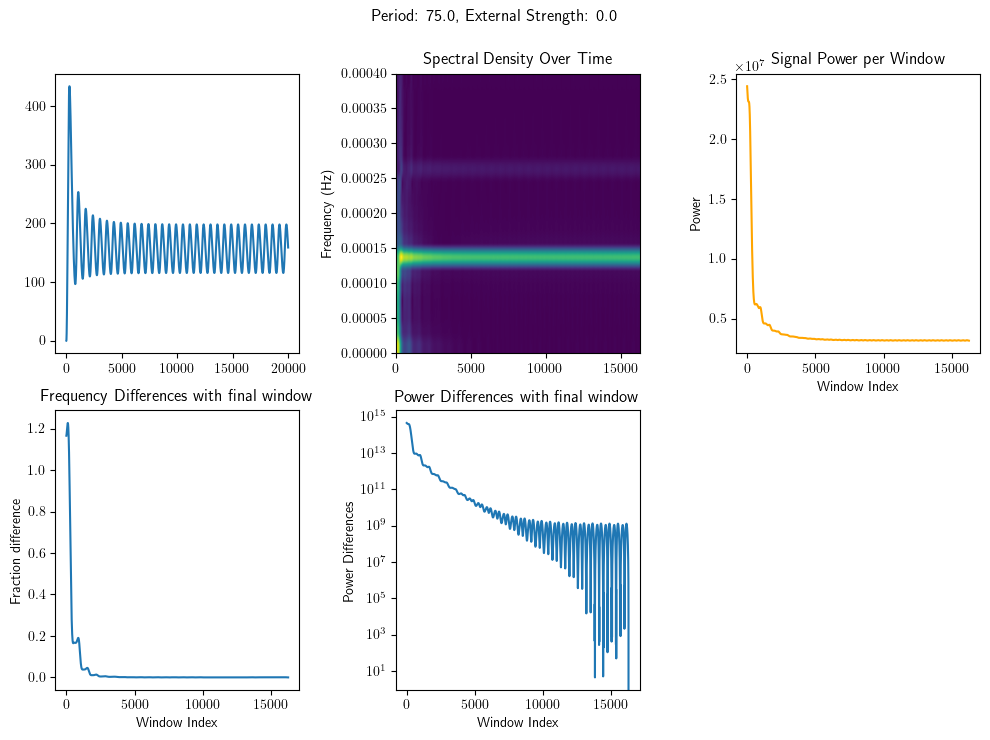

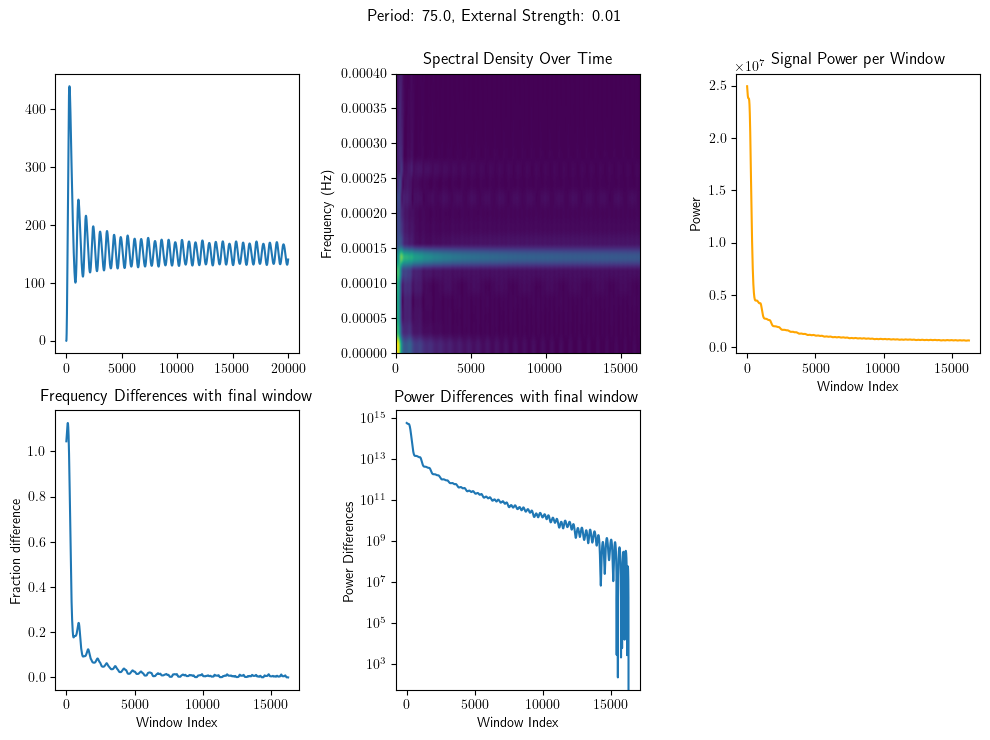

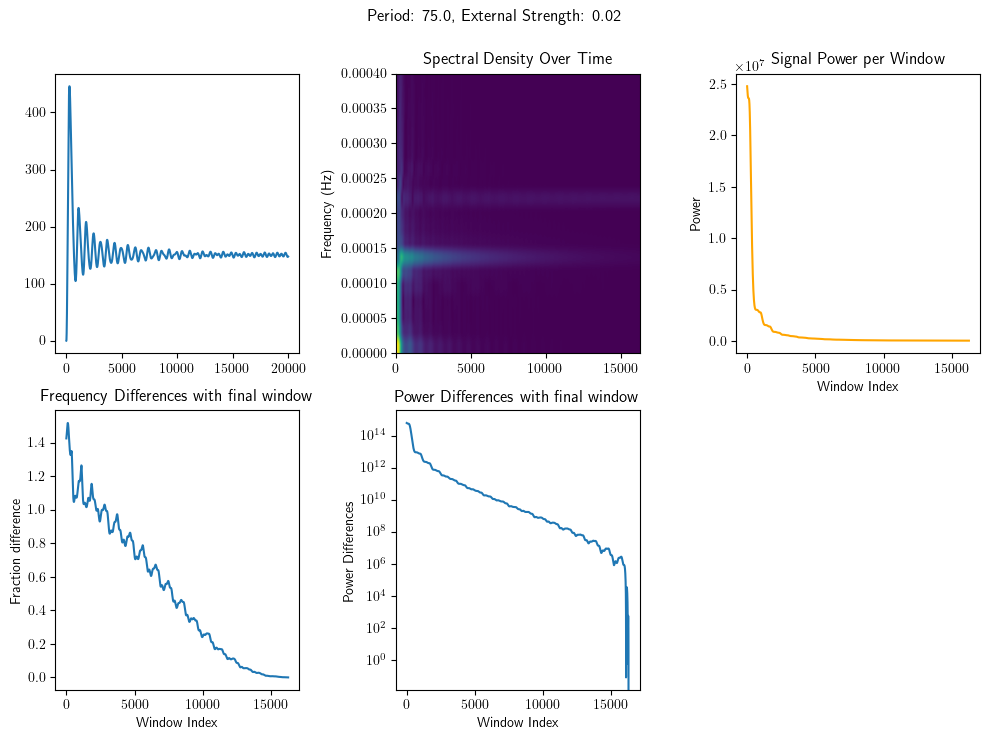

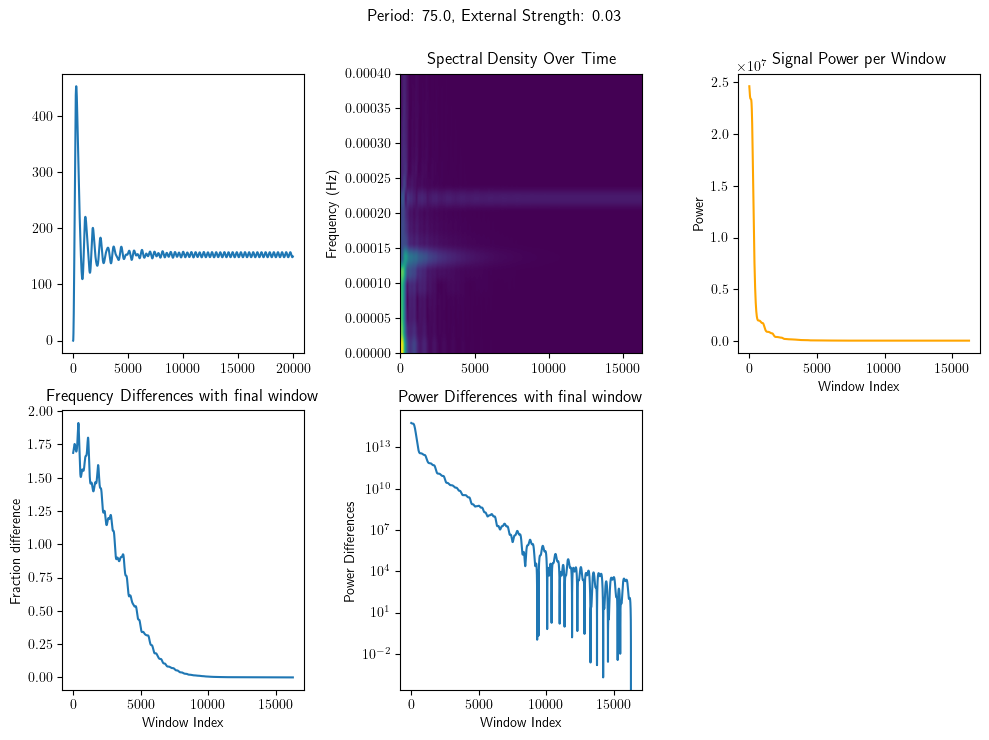

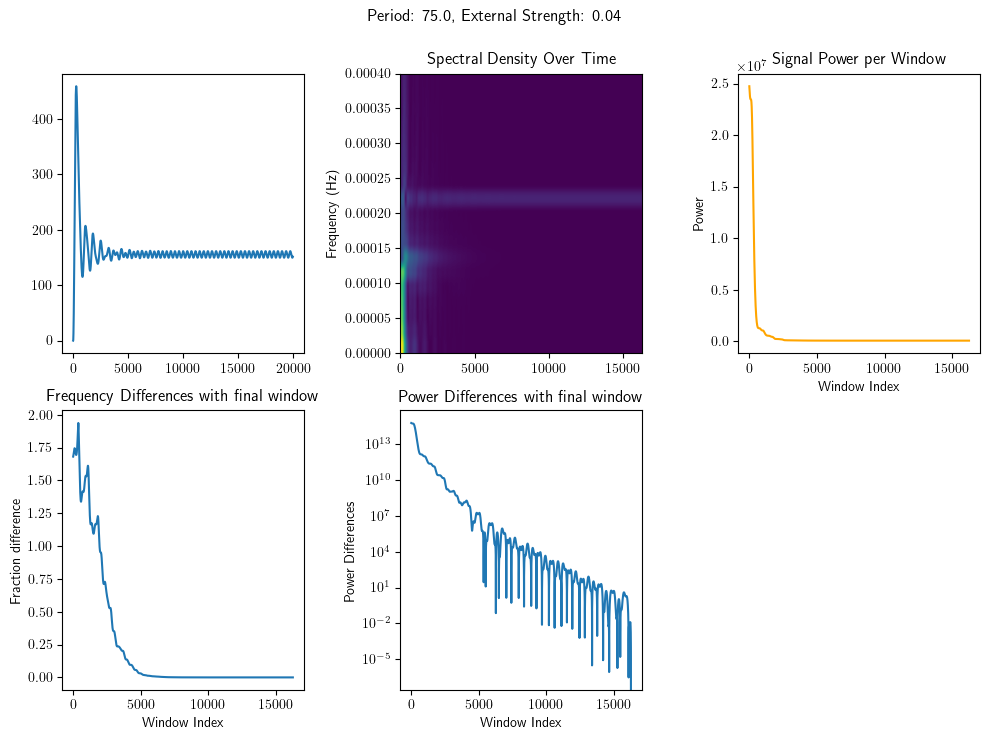

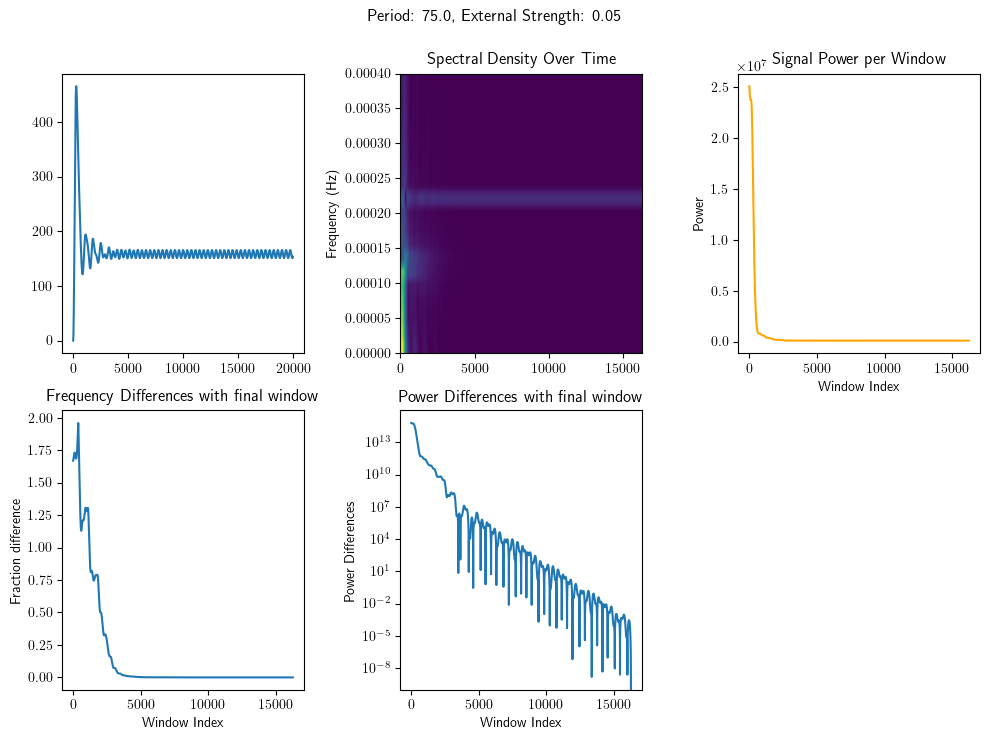

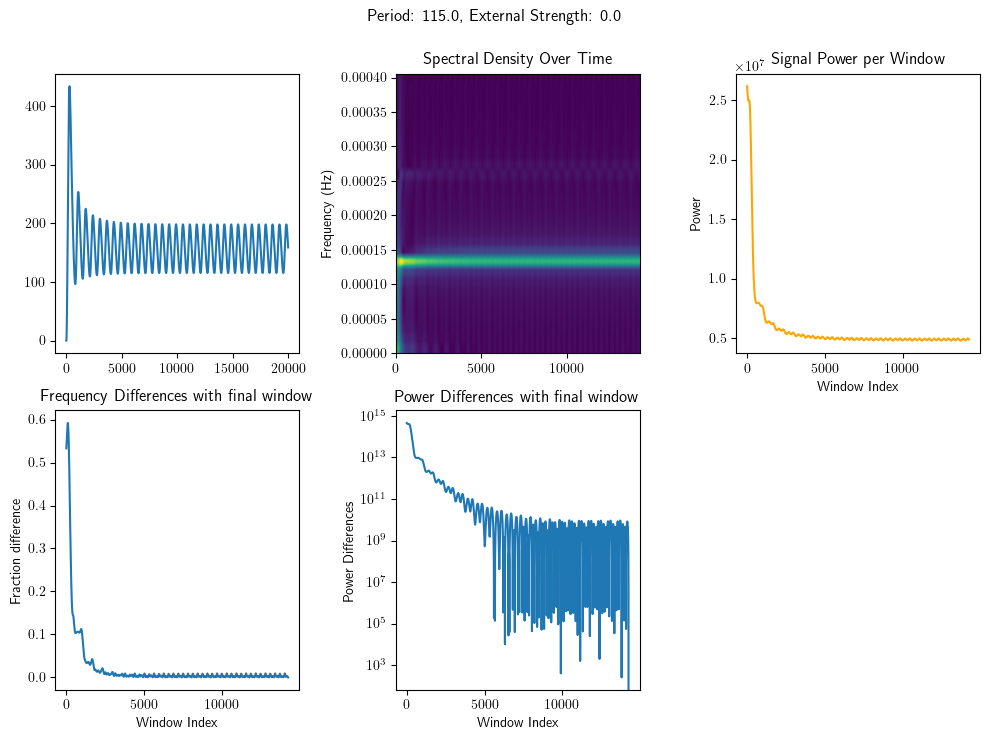

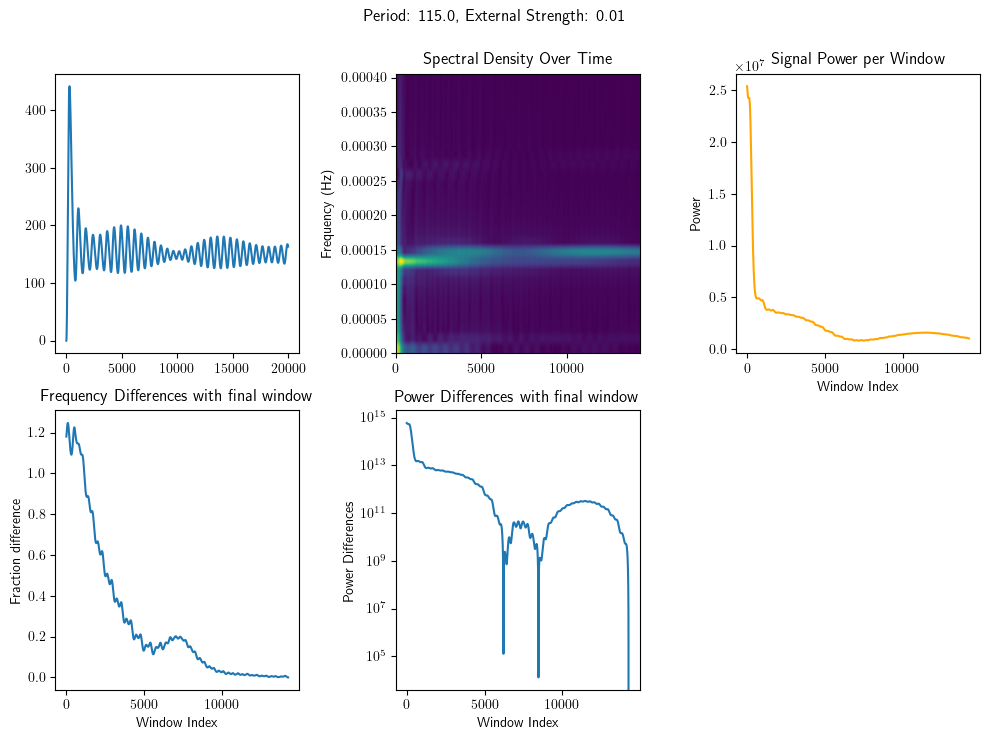

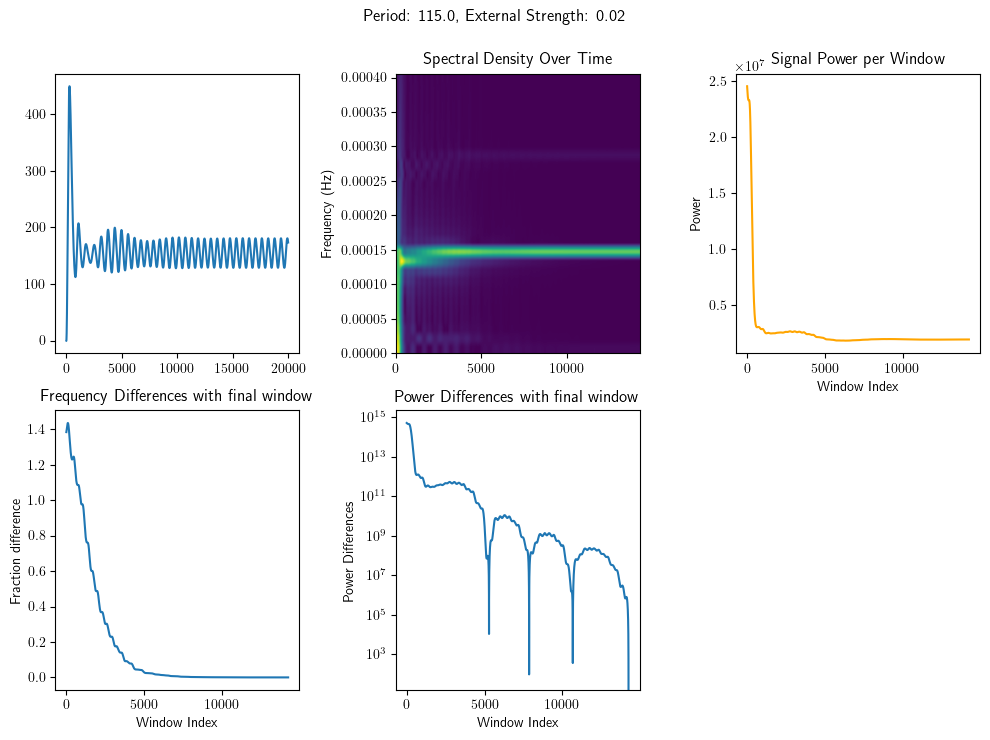

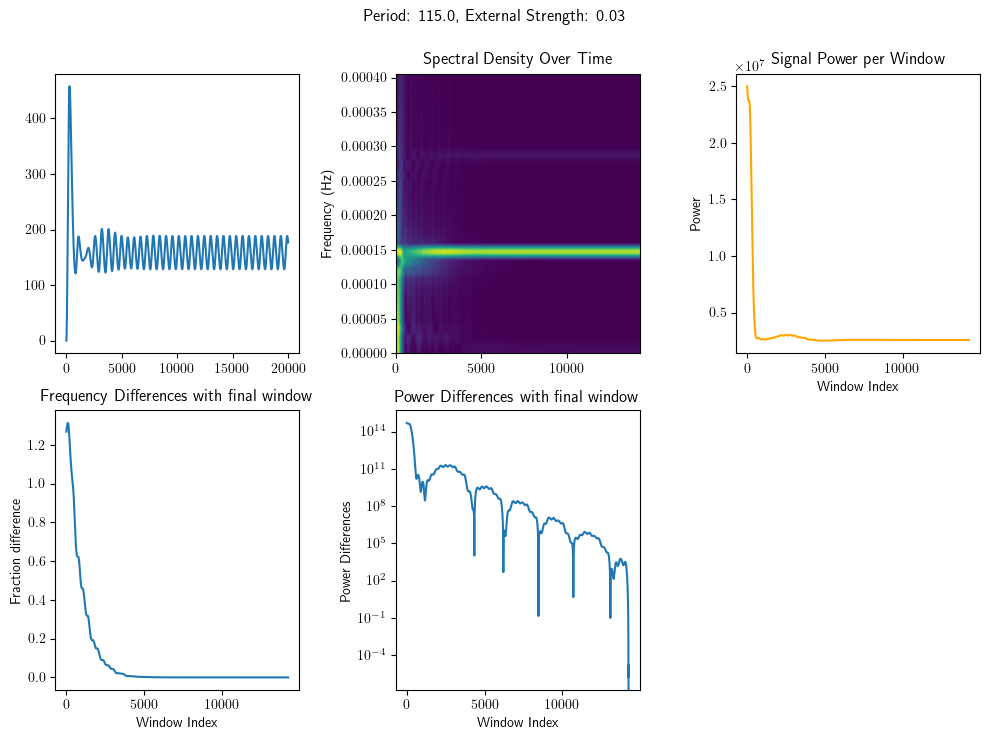

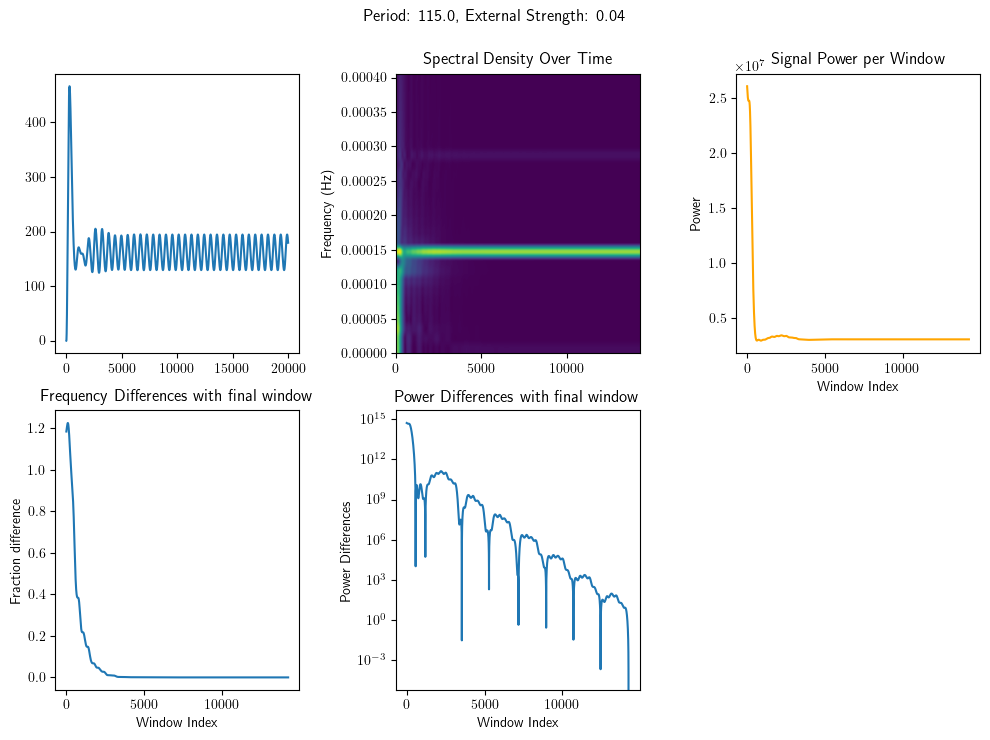

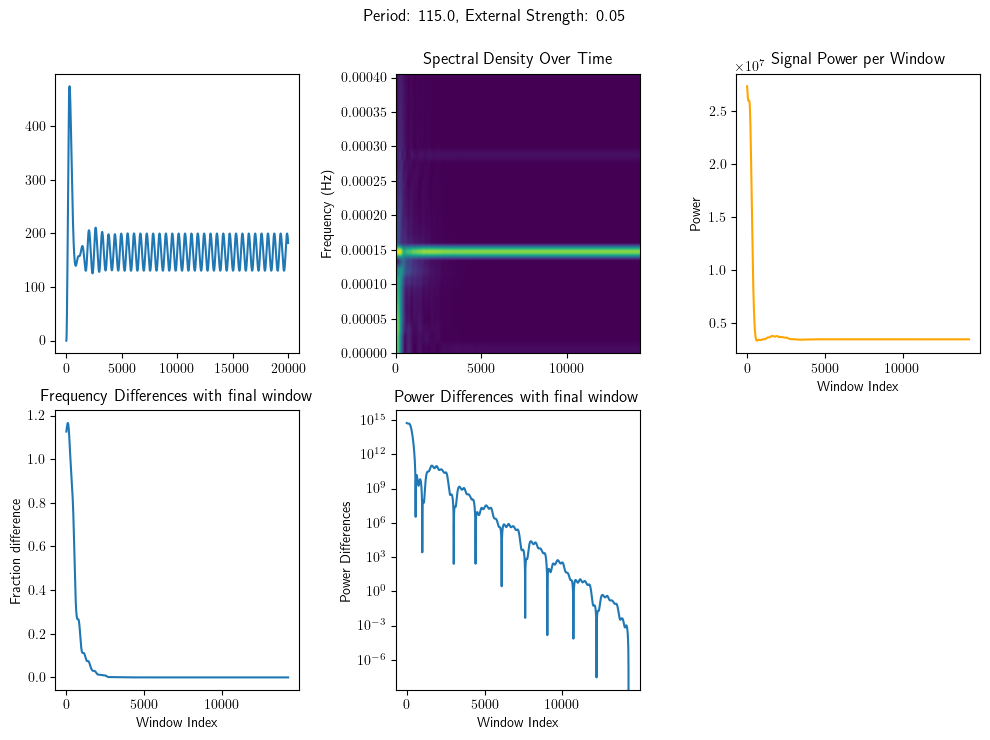

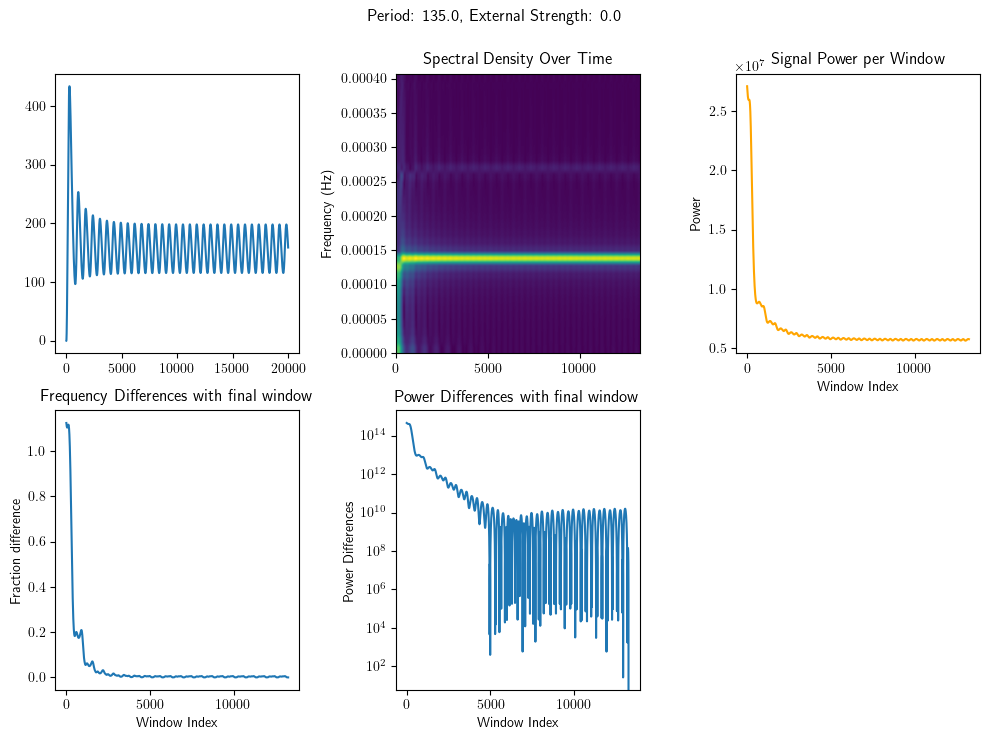

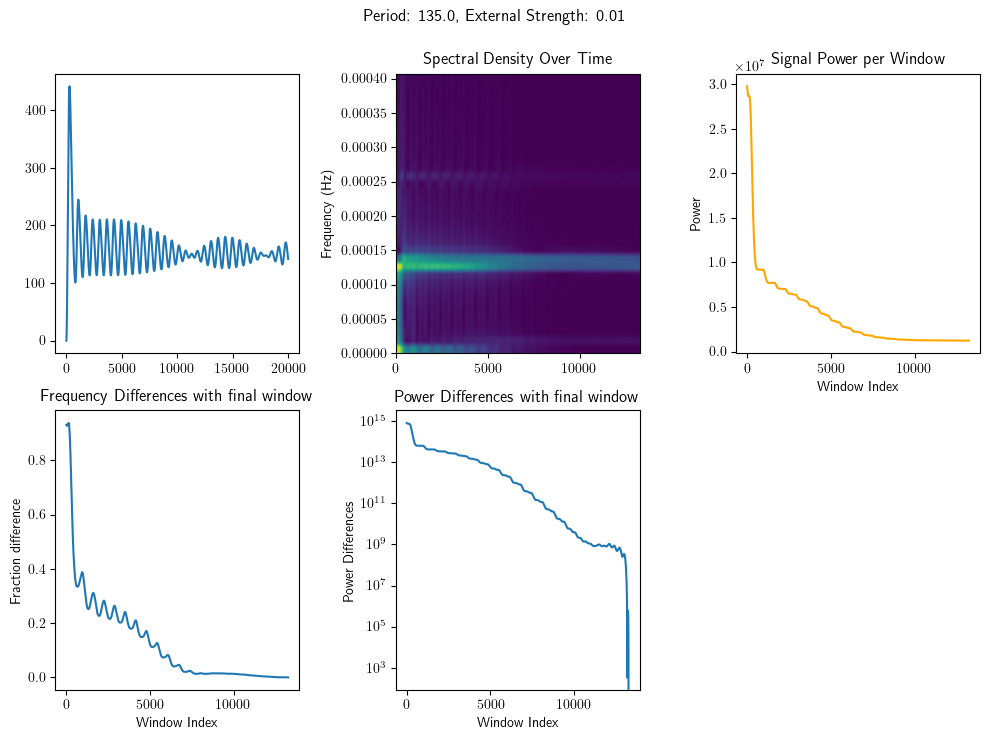

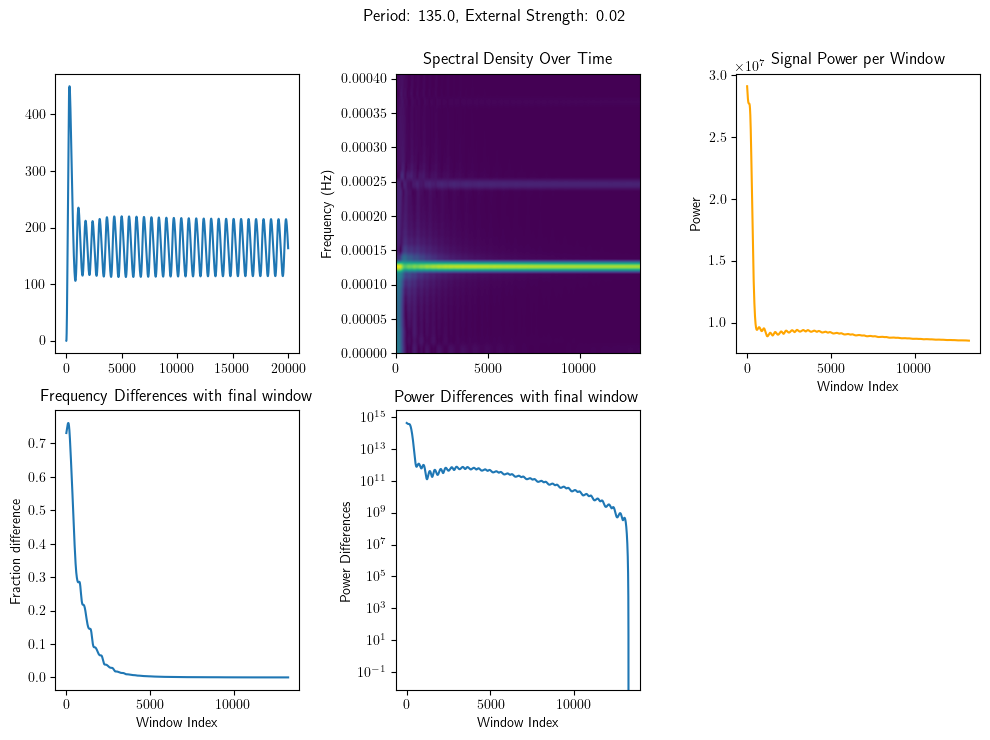

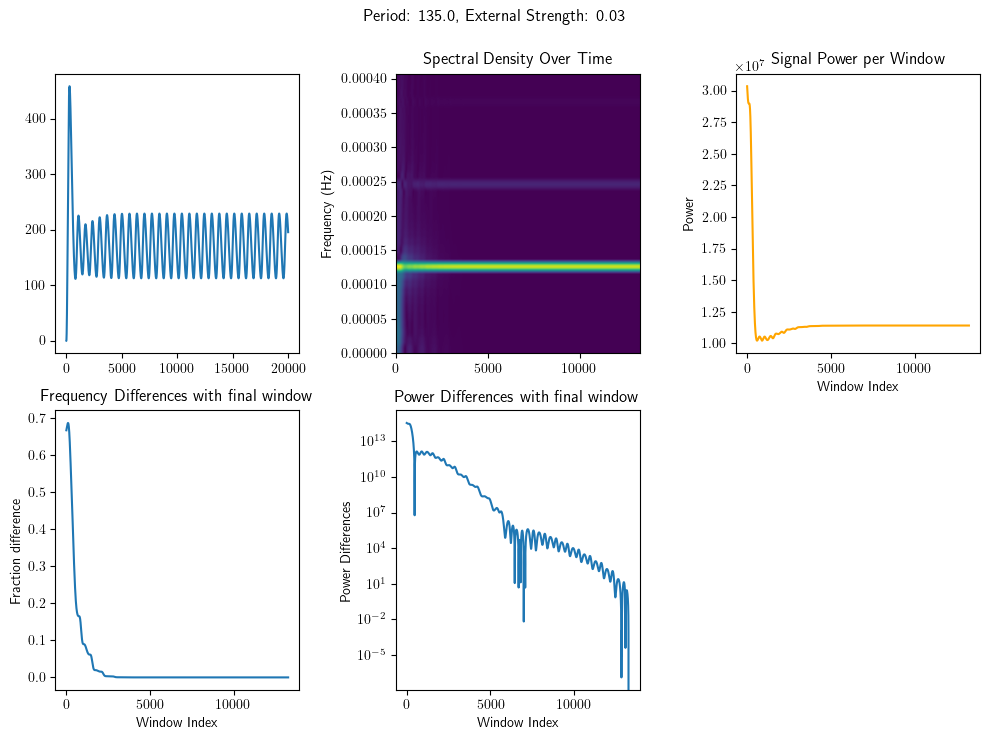

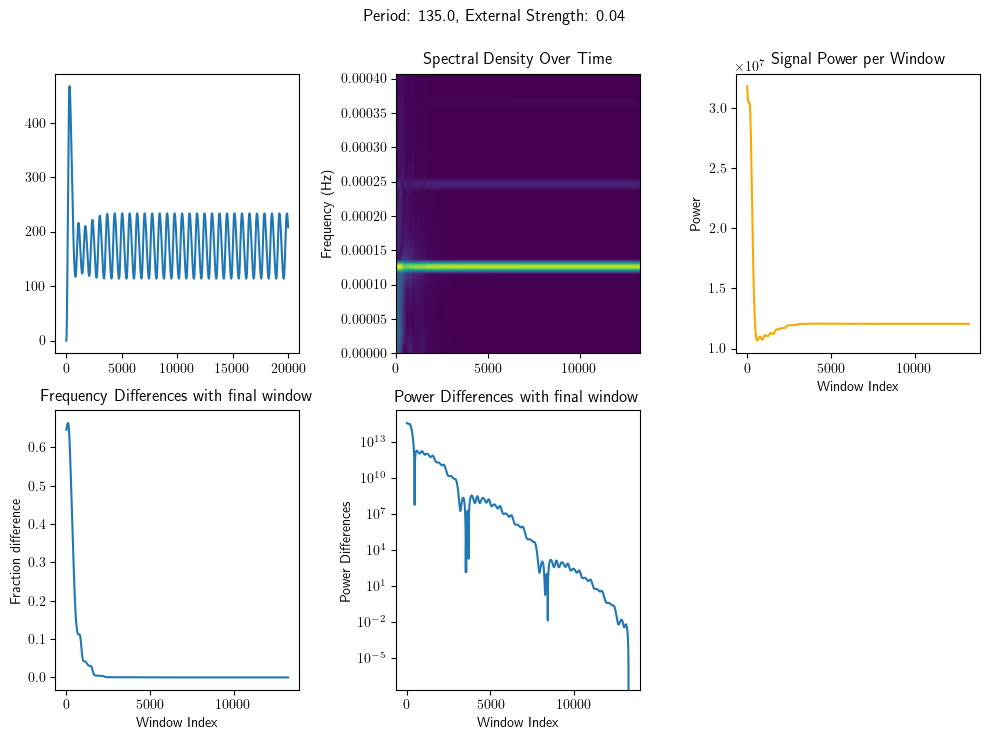

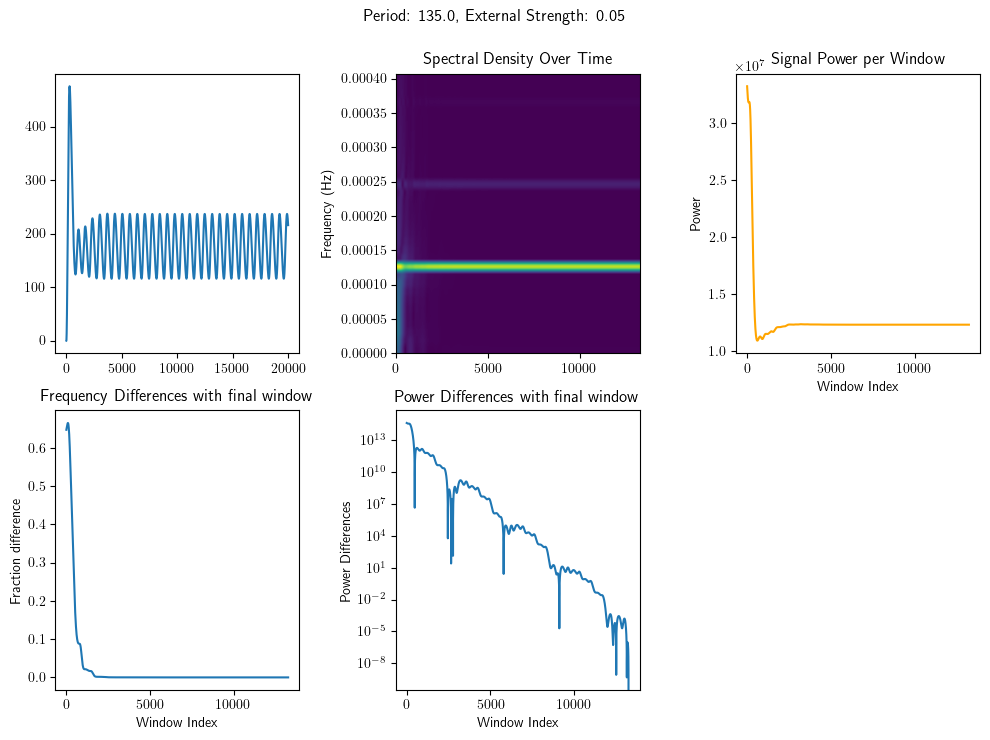

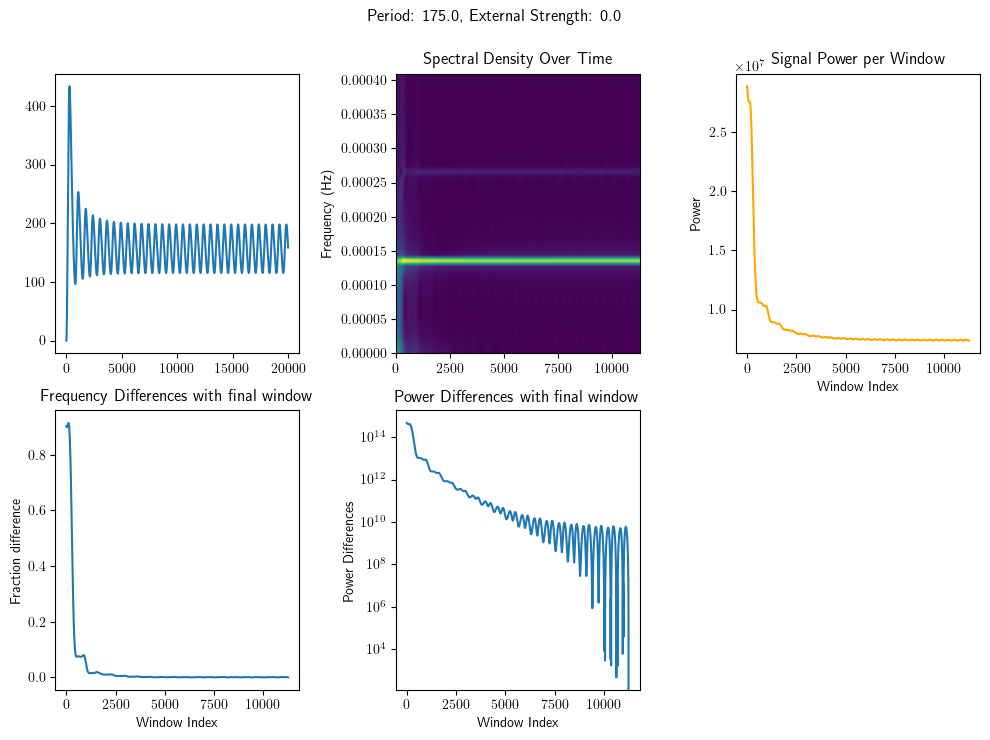

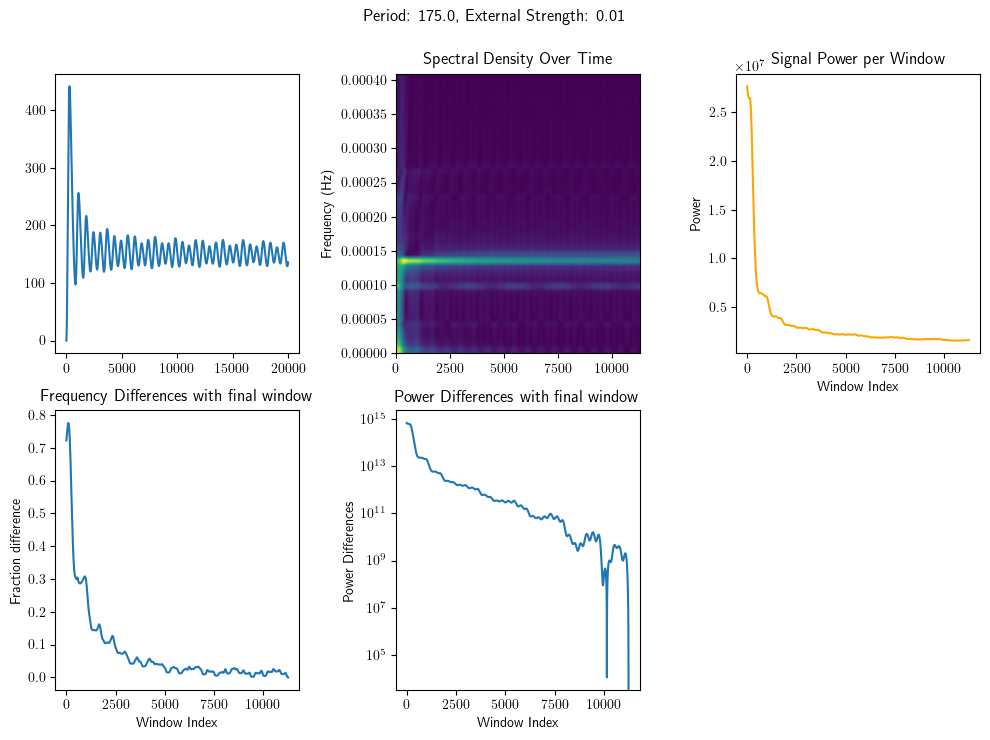

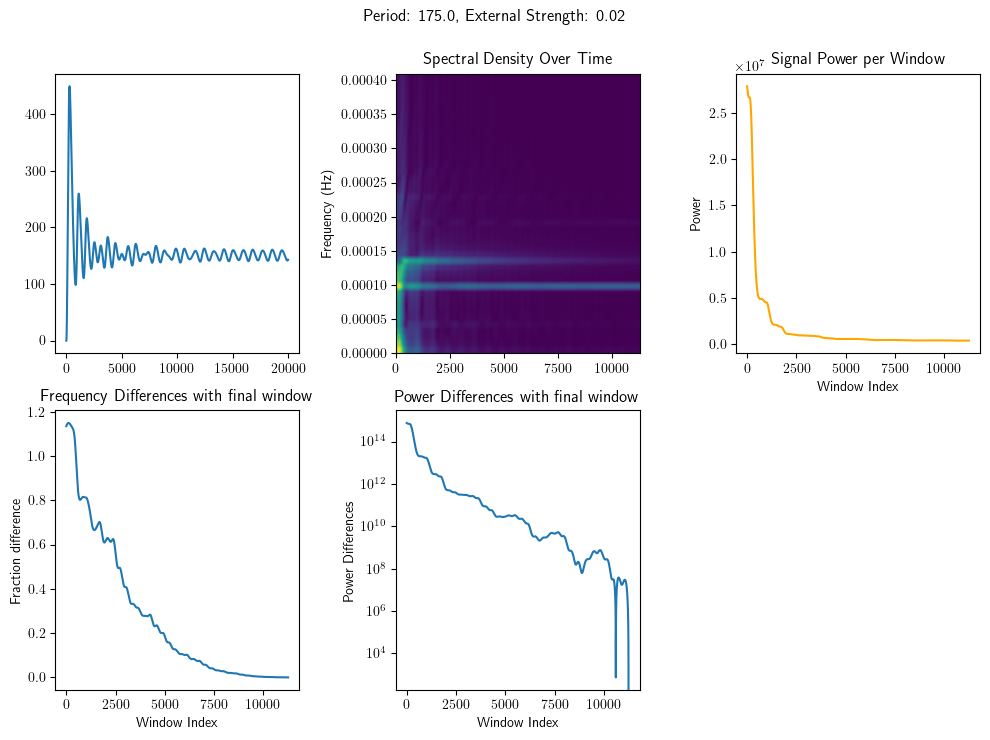

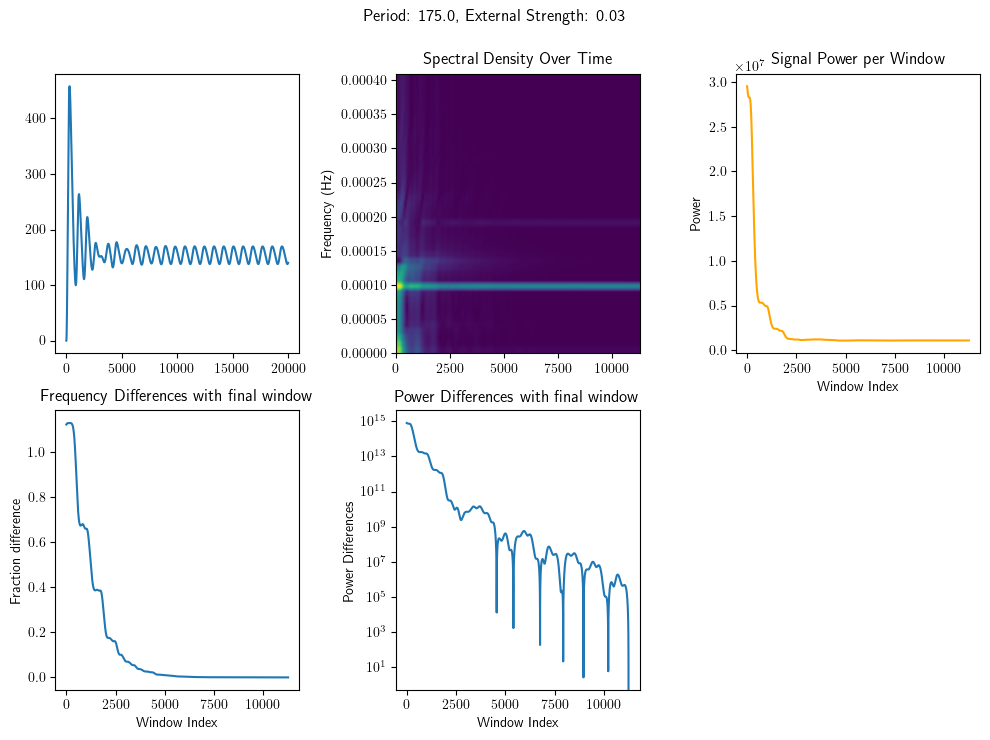

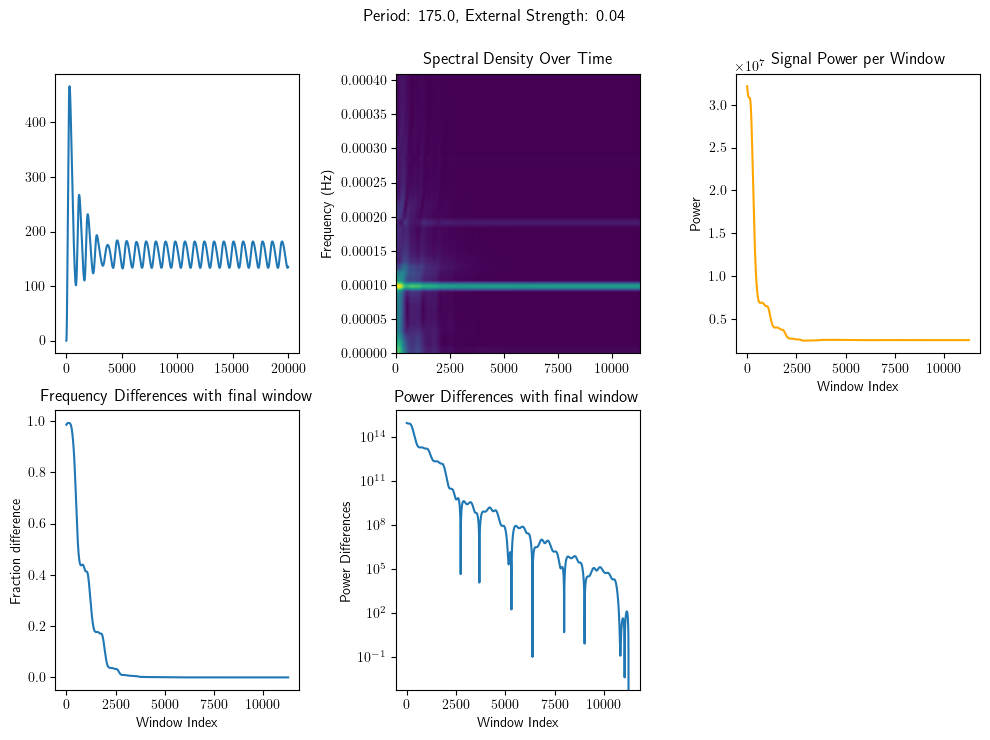

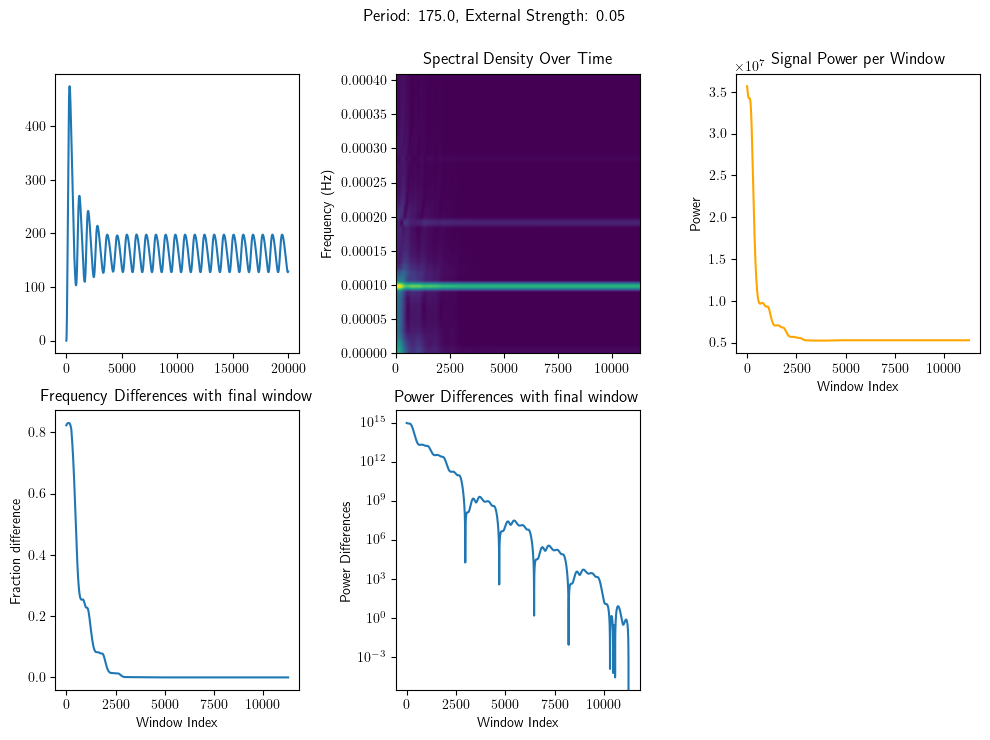

In [279]:
for i_period in range(len(periods)):
    for i_ext_strength in strength_range:
        period_system = periods[i_period]
        print(period_system, external_strength[i_ext_strength])
        window_size = int(10*period_system / dt)  # Convert period to number of samples
        num_windows = results_osc_strength.shape[2] - window_size + 1

        fft_matrix, freqs, power_per_window = compute_and_plot_fft_spectrogram(results_osc_strength[i_period, i_ext_strength, :,0], (dt*60)**-1, window_size, cutoff_freq=1/(40*60))

        freq_diff, power_diff = freqs_differences(fft_matrix, power_per_window)

        #plotting
        plt.figure(figsize=(10, 7.5))
        plt.suptitle(f'Period: {period_system}, External Strength: {external_strength[i_ext_strength]}')
        plt.subplot(2, 3, 1)
        plt.plot(results_osc_strength[i_period, i_ext_strength, :, 0])

        plt.subplot(2, 3, 2)
        extent = [0, num_windows, freqs[0], freqs[-1]]
        plt.imshow(fft_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')
        plt.title('Spectral Density Over Time')
        plt.ylabel('Frequency (Hz)')

        # --- Plot signal power per window
        plt.subplot(2, 3, 3)
        plt.plot(power_per_window, color='orange')
        plt.title('Signal Power per Window')
        plt.xlabel('Window Index')
        plt.ylabel('Power')

        plt.subplot(2, 3,  4)
        plt.plot(freq_diff[:])
        plt.ylabel('Fraction difference')
        plt.xlabel('Window Index')
        plt.title('Frequency Differences with final window')

        plt.subplot(2, 3, 5)
        plt.plot(power_diff[:])
        plt.xlabel('Window Index')
        plt.ylabel('Power Differences')
        plt.yscale('log')
        plt.title('Power Differences with final window')
        plt.tight_layout()